In [1]:
from statsbombpy import sb
import pandas as pd
import numpy as np
from mplsoccer import VerticalPitch,Pitch
from highlight_text import ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import seaborn as sns
from functools import reduce


In [2]:
# função para pegar as partidas de um time específico

def team_matches(team, df_matches):
    team_matches = df_matches.query((f'home_team == "{team}" or away_team == "{team}"'))
    return team_matches.sort_values(by='match_date', ascending=False)

In [3]:
# Partidas da Holanda

team = "Netherlands"
df_matches = sb.matches(competition_id=55, season_id=282) # partidas da eurocopa 2024

team_matches = team_matches(team, df_matches)

In [4]:
# Eventos da partida Holanda x Inglaterra
match = sb.events(match_id=3942819)

# função para tratar eventos da partida
def split_locations(df):
    df[['x', 'y']] = df['location'].apply(pd.Series)
    df[['pass_end_x', 'pass_end_y']] = df['pass_end_location'].apply(pd.Series) # separar localização final dos passes
    df[['carry_end_x', 'carry_end_y']] = df['carry_end_location'].apply(pd.Series) # separar localização final das conduções
    for shot in df['shot_end_location']:
        try:
            df['shot_end_x'] = shot[0]
            df['shot_end_y'] = shot[1]
            df['shot_end_z'] = shot[2]
        except:
            pass

    
    
    
    return df

In [5]:
# Tratando os eventos da partida

match_events = split_locations(match)

In [6]:
# Criando uma lista de jogadores da equipe analisada
team = "Netherlands"

players_team = [match_events.query(f'team == "{team}"')['player'].unique()]

players_team = list(players_team[0][1:])

In [7]:
# Lista de eventos
events_types = ['Ball Receipt*', 'Pass', 'Dribble', 'Shot', 'Interception', 'Foul Committed', 'Foul Won', 'Miscontrol', 'Block', 'Dispossessed', 'Ball Recovery']

# Lista de acoes com bola (touches)
touches=['Pass', 'Ball Receipt*', 'Carry', 'Clearance', 'Foul Won', 'Block',
'Ball Recovery', 'Duel', 'Dribble', 'Interception', 'Miscontrol', 'Shot']


# Iterador (for) para tabela de agregações

In [8]:
players_dicts = []

for player in players_team:
    player_dict = {}
    player_dict['Name'] = player
    for event in events_types:
        specific_event = match_events[(match_events.player==player)&(match_events.type==event)]
        data_event = len(specific_event)
        player_dict[event] = data_event
    player_long_passes = match_events[(match_events.type=="Pass")&(match_events.player==player)&(match_events.pass_length>30)]
    player_dict['Long Passes'] = len(player_long_passes)
    player_goals = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Goal")]
    player_dict['Goals'] = len(player_goals)
    player_assists = match_events[(match_events.type=="Pass")&(match_events.player==player)&(match_events.pass_goal_assist==True)]
    player_dict['Assists'] = len(player_assists)
    player_crosses = match_events[(match_events.type=="Pass")&(match_events.player==player)&(match_events.pass_cross==True)]
    player_dict['Crosses'] = len(player_crosses)
    players_dicts.append(player_dict)






In [9]:
df_team = pd.DataFrame(players_dicts)

In [10]:
df_team

,Name,Ball Receipt*,Pass,Dribble,Shot,Interception,Foul Committed,Foul Won,Miscontrol,Block,Dispossessed,Ball Recovery,Long Passes,Goals,Assists,Crosses
0,Virgil van Dijk,53,66,0,1,1,1,0,0,0,0,2,10,0,0,0
1,Nathan Aké,33,38,1,0,0,0,0,0,2,0,1,5,0,0,1
2,Stefan de Vrij,53,62,0,0,4,0,1,0,1,0,0,10,0,0,0
3,Jerdy Schouten,48,54,0,0,0,2,1,1,0,0,5,6,0,0,0
4,Denzel Dumfries,41,30,1,2,0,2,1,1,3,2,0,4,0,0,0
5,Bart Verbruggen,28,36,0,0,0,0,0,0,0,0,6,19,0,0,0
6,Memphis Depay,11,8,0,0,0,0,0,1,0,1,0,1,0,0,0
7,Xavi Simons,48,40,1,2,1,0,2,1,2,1,2,7,1,0,0
8,Tijjani Reijnders,36,40,0,0,2,1,1,0,3,0,4,3,0,0,0
9,Donyell Malen,14,4,0,1,1,0,0,1,1,1,2,1,0,0,0


# Gráficos

### Bolas recebidas

In [11]:
# Função para localização de eventos

def event_map(event, player):
    df_event = match_events[(match_events.player==player)&(match_events.type==event)]

    # campo
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_zorder=2, line_color='black')
    fig, ax = pitch.draw(figsize=(16, 11),constrained_layout=True, tight_layout=False)
    fig.set_facecolor('white')

    # bolas recebidas
    pitch.arrows(df_event.x, df_event.y,
             df_event.x, df_event.y, width=8, 
             headwidth=8, headlength=5, color=color, ax=ax, zorder=2, label = event)
    
    ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=20, loc='best')
    ax_title = ax.set_title(f'{player} {event.lower()} on the pitch', fontsize=30,color='black')


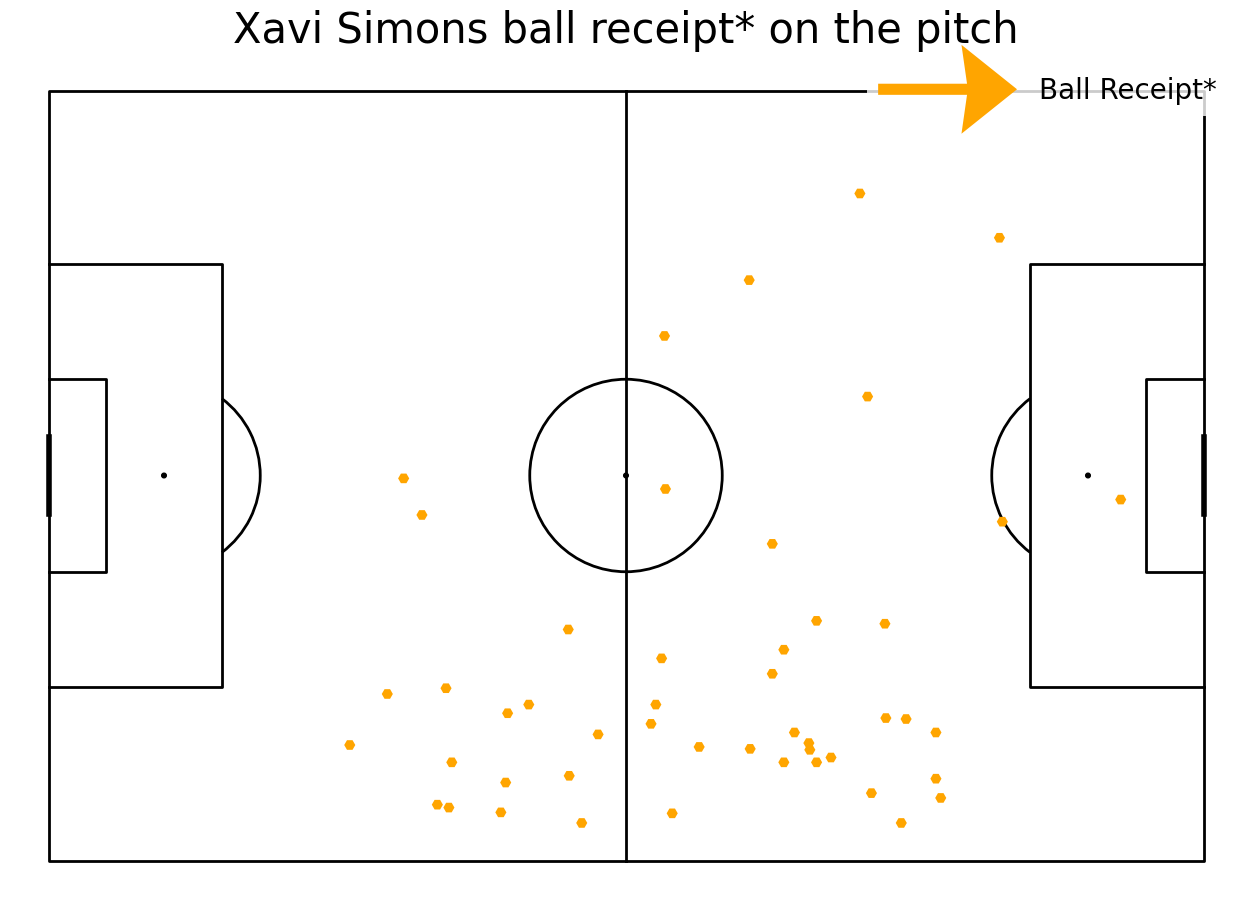

In [12]:
event = 'Ball Receipt*'
player = 'Xavi Simons'
color = 'orange'

event_map(event,player)

## Passes

In [13]:
# Função para direção de passes

def pass_map(player):
    correct_passes = match_events[(match_events.player==player)
                                  &(match_events.type=='Pass')
                                  &(match_events.pass_outcome.isna())]
    wrong_passes = match_events[(match_events.player==player)
                                &(match_events.type=='Pass')
                                &(match_events.pass_outcome=='Incomplete')]
    offside_passes = match_events[(match_events.player==player)
                                  &(match_events.type=='Pass')
                                  &(match_events.pass_outcome=='Pass Offside')]
    out_passes = match_events[(match_events.player==player)
                                &(match_events.type=='Pass')
                                &(match_events.pass_outcome=='Out')]

    # campo
    pitch_color = '#50C878'
    pitch = Pitch(pitch_type='statsbomb', pitch_color=pitch_color, line_zorder=2, line_color='white')
    fig, ax = pitch.draw(figsize=(16, 11),constrained_layout=True, tight_layout=False)
    fig.set_facecolor('white')

    # passes certos
    pitch.arrows(correct_passes.x, correct_passes.y,
             correct_passes.pass_end_x, correct_passes.pass_end_y, width=3, 
             headwidth=8, headlength=5, color='blue', ax=ax, zorder=2, label = 'Correct')
    
    # passes incompletos
    pitch.arrows(wrong_passes.x, wrong_passes.y,
             wrong_passes.pass_end_x, wrong_passes.pass_end_y, width=3, 
             headwidth=8, headlength=5, color='red', ax=ax, zorder=2, label = 'Incomplete')
    # passes para atletas impedidos
    pitch.arrows(offside_passes.x, offside_passes.y,
             offside_passes.pass_end_x, offside_passes.pass_end_y, width=3, 
             headwidth=8, headlength=5, color='yellow', ax=ax, zorder=2, label = 'Offside')
    # passes para fora
    pitch.arrows(out_passes.x, out_passes.y,
             out_passes.pass_end_x, out_passes.pass_end_y, width=3, 
             headwidth=8, headlength=5, color='black', ax=ax, zorder=2, label = 'Out')

    
    ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=20, loc='best')
    ax_title = ax.set_title(f'{player} passes on the pitch', fontsize=30,color='black')


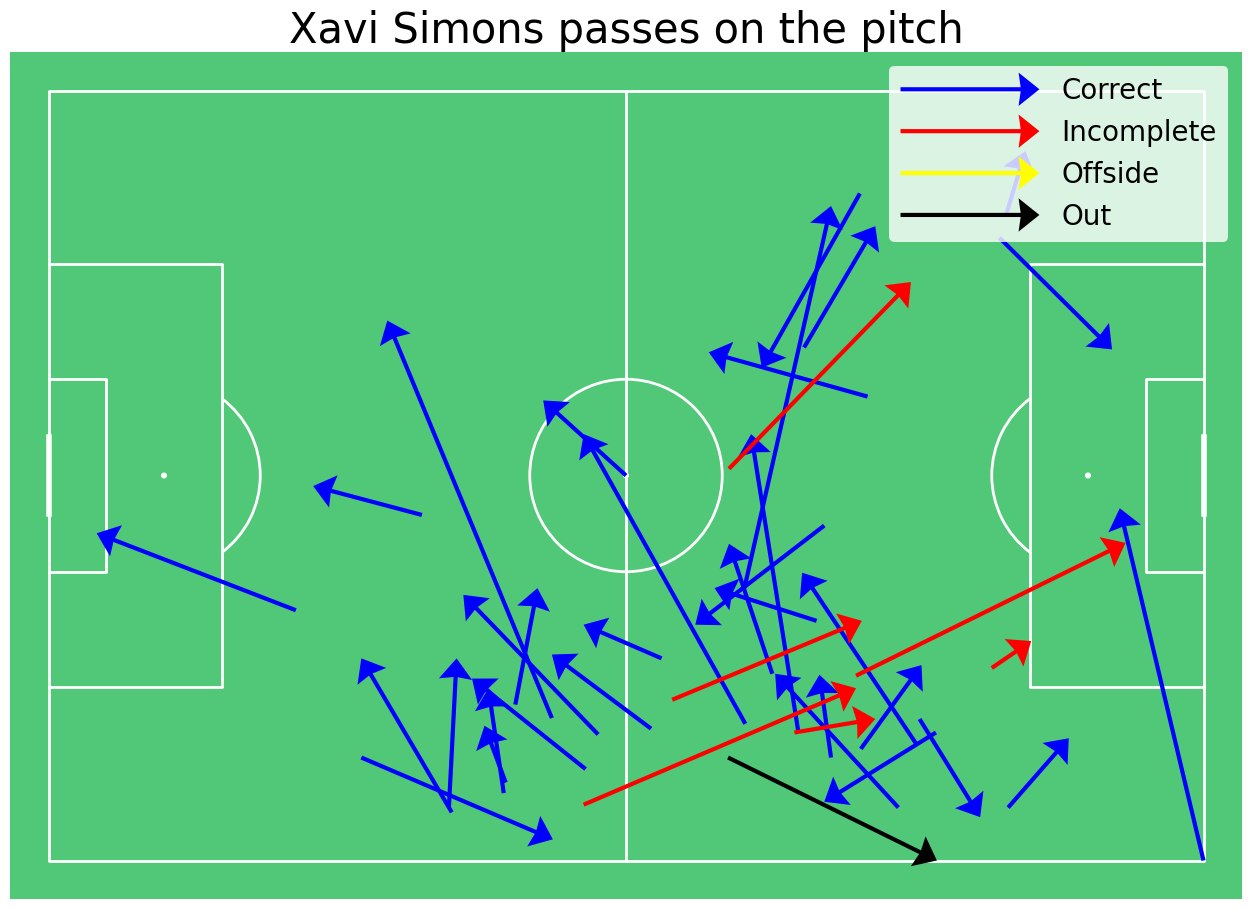

In [14]:
event = 'Pass'
player = 'Xavi Simons'
color = 'orange'

pass_map(player)

### Chutes

In [15]:
saved_shots = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Saved")]

In [16]:
goals = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Goal")]

In [17]:
blocked_shots = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Blocked")]

In [18]:
import pandas as pd
import numpy as np

for shot in match_events['shot_end_location']:
    try:
        print(shot)
    except:
        pass

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [19]:
for shot in saved_shots['shot_end_location']:
    print(type(shot))

<class 'list'>


In [20]:
list(saved_shots['shot_end_location'])

[[118.7, 40.0, 1.6]]

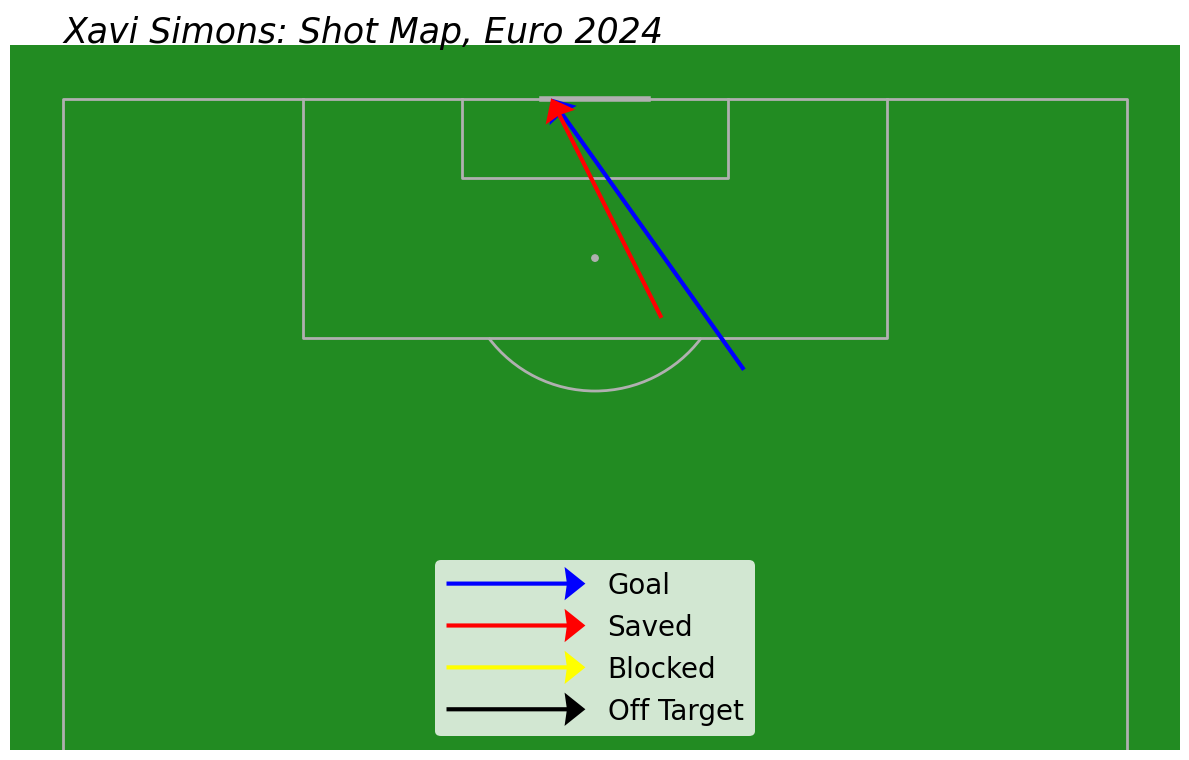

In [21]:
saved_shots = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Saved")]

blocked_shots = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Blocked")]

off_target_shots = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &((match_events.shot_outcome=="Post") | (match_events.shot_outcome=="Off T"))]


goals = match_events[(match_events.type=="Shot")
                                &(match_events.player==player)
                                &(match_events.shot_outcome=="Goal")]

pitch = VerticalPitch(pitch_type='statsbomb',half=True,pad_bottom=-11, pitch_color='forestgreen')
fig, ax = pitch.draw(figsize=(12, 10))

shot_colour='white'
goal_colour='blue'

# goals
pitch.arrows(goals.x, goals.y,
             goals.shot_end_x, goals.shot_end_y, width=3, 
             headwidth=8, headlength=5, color='blue', ax=ax, zorder=2, label = 'Goal')

# saved
pitch.arrows(saved_shots.x, saved_shots.y,
             saved_shots.shot_end_x, saved_shots.shot_end_y, width=3, 
             headwidth=8, headlength=5, color='red', ax=ax, zorder=2, label = 'Saved')


# blocked
pitch.arrows(blocked_shots.x, blocked_shots.y,
             blocked_shots.shot_end_x, blocked_shots.shot_end_y, width=3, 
             headwidth=8, headlength=5, color='yellow', ax=ax, zorder=2, label = 'Blocked')

# off target
pitch.arrows(off_target_shots.x, off_target_shots.y,
             off_target_shots.shot_end_x, off_target_shots.shot_end_y, width=3, 
             headwidth=8, headlength=5, color='black', ax=ax, zorder=2, label = 'Off Target')

# shots = pitch.scatter(player_shots_df.x, player_shots_df.y
# #make size relative to xG value
# s=player_shots_df.shot_statsbomb_xg*1000,
# c=shot_colour,
# label='Shots',
# marker='o',
# alpha=0.5,
# ax=ax)

# goals = pitch.scatter(player_goals_df.x, player_goals_df.y,
# #make size relative to xG value
# s=player_goals_df.shot_statsbomb_xg*1000,
# c='white',
# edgecolors=goal_colour,
# label='Goals',
# marker='football',
# ax=ax)

#plot the legend
ax.legend(facecolor='white', handlelength=5, edgecolor='None', fontsize=20, loc='best')

ax_text(0, 125, f'{player}: Shot Map, Euro 2024', ha='left', c='black',va='center', fontsize=25,ax=ax,style='italic')

### Ações com bola

In [22]:
touches=['Pass', 'Ball Receipt*', 'Carry', 'Clearance', 'Foul Won', 'Block',
'Ball Recovery', 'Duel', 'Dribble', 'Interception', 'Miscontrol', 'Shot']

player_df=match_events[(match_events.player==player)&(match_events.type.isin(touches))]

#criando degradê de cores
colour1="forestgreen"
colour2="#EBBC04"
colour3="#e21017"
cmaplist = [colour1, colour2, colour3]
cmap = LinearSegmentedColormap.from_list("", cmaplist)


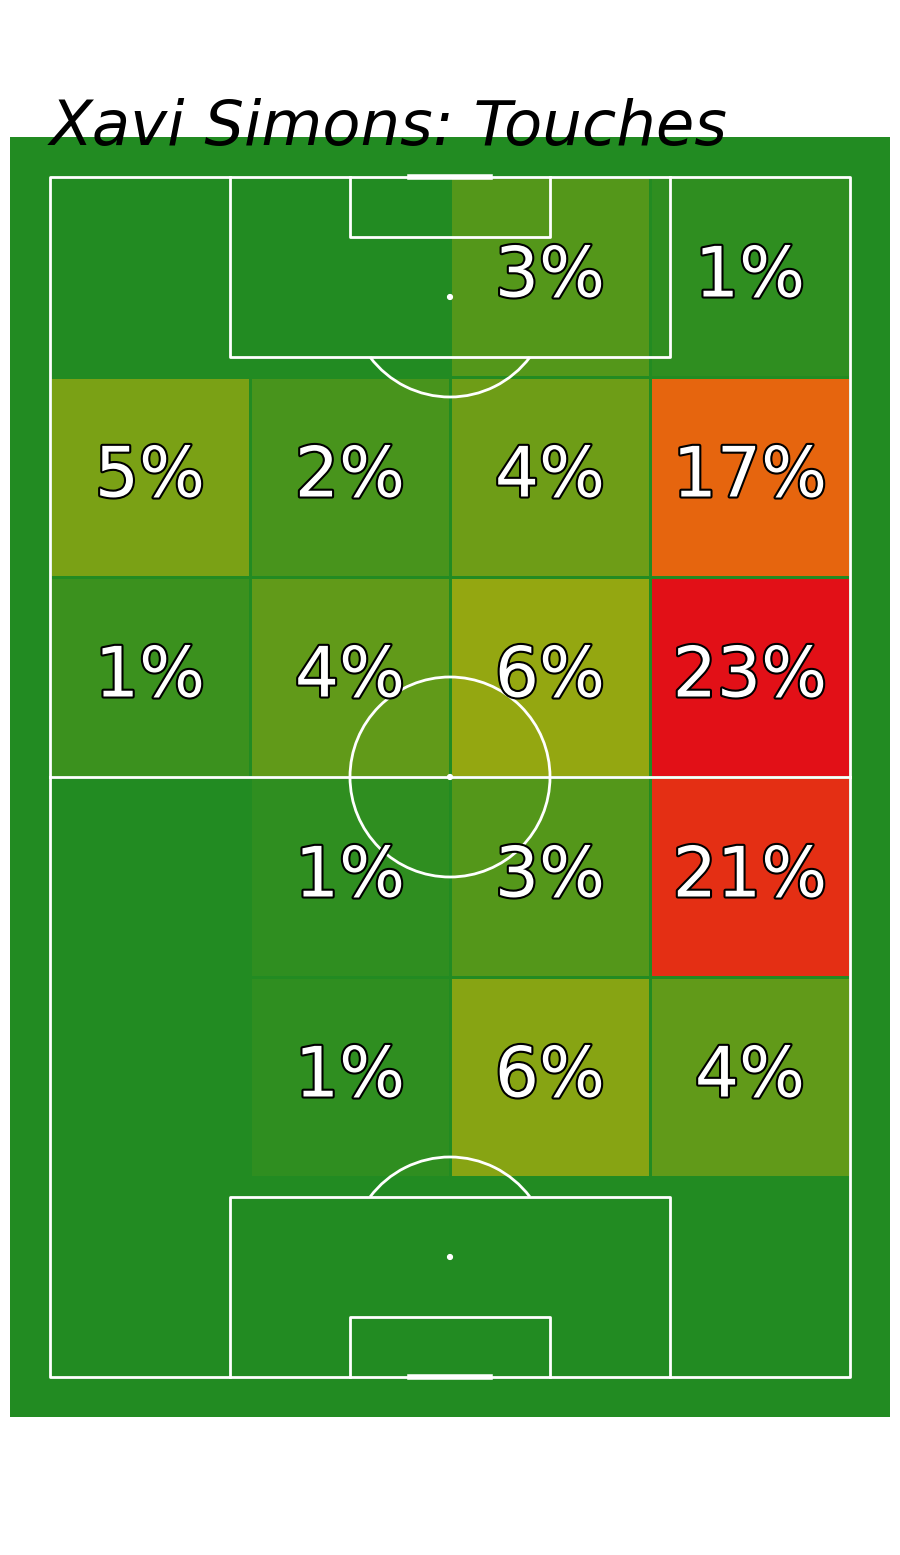

In [23]:
path_eff = [path_effects.Stroke(linewidth=3, foreground='black'),
            path_effects.Normal()]

#create a grid of pitches
#define pitch style
pitch = VerticalPitch(pitch_type='statsbomb', line_zorder=2, pitch_color='forestgreen', line_color='white', linewidth=2,half=False)

#create a grid - in this example, one row of two pitches
fig, axs = pitch.grid(nrows=1, ncols=1
                      ,figheight=16,
                      grid_width=0.65,
                      endnote_height=0.03, endnote_space=0.05,
                      axis=False,title_space=0.02, title_height=0.06, grid_height=0.8)

#get data for heatmap
bin_statistic1 = pitch.bin_statistic(player_df.x, player_df.y, statistic='count',
bins=(6, 4),normalize=True)


#calculate vmax value
#we want both our heatmaps to use the same colour spectrum
vmax=bin_statistic1['statistic'].max()
# vmax2=bin_statistic2['statistic'].max()

# if vmax1>vmax2:
#   vmax=vmax1
# else:
#   vmax=vmax2

#set vmin as zero
vmin=0

#plot heatmap for player
heatmap = pitch.heatmap(bin_statistic1, ax=axs['pitch'], cmap=cmap, vmax=vmax, vmin=vmin, color = 'forestgreen')

#add percentages for each zone
annotate1 = pitch.label_heatmap(bin_statistic1, color='white',
                                path_effects=path_eff, fontsize=50, ax=axs['pitch'],
                                str_format='{:.0%}',
                                ha='center', va='center',
                                exclude_zeros=True)

#add name of player to the top of the heatmap
ax_text(0, 125, f'{player}: Touches', ha='left', c='black',va='center', fontsize=45,ax=axs['pitch'],style='italic')




In [24]:
match_events.columns

Index(['50_50', 'bad_behaviour_card', 'ball_receipt_outcome',
       'block_deflection', 'block_save_block', 'carry_end_location',
       'clearance_aerial_won', 'clearance_body_part', 'clearance_head',
       'clearance_left_foot', 'clearance_right_foot', 'counterpress',
       'dribble_outcome', 'duel_outcome', 'duel_type', 'duration',
       'foul_committed_advantage', 'foul_committed_card',
       'foul_committed_penalty', 'foul_won_advantage', 'foul_won_defensive',
       'foul_won_penalty', 'goalkeeper_body_part', 'goalkeeper_end_location',
       'goalkeeper_outcome', 'goalkeeper_position', 'goalkeeper_punched_out',
       'goalkeeper_technique', 'goalkeeper_type', 'id', 'index',
       'injury_stoppage_in_chain', 'interception_outcome', 'location',
       'match_id', 'minute', 'off_camera', 'out', 'pass_aerial_won',
       'pass_angle', 'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assis

In [25]:
match_events['shot_outcome'].unique()

array([nan, 'Goal', 'Saved', 'Blocked', 'Post', 'Off T'], dtype=object)